In [3]:
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt

In [4]:
# Input: (Parquet File) mapillary coverage lines per tile 

# Output: Buffered lines per tile for pano only and all

In [5]:
#mapillary_coverage_23_bb = gpd.read_parquet("mapillary_coverage_23_bb.parquet")
#mapillary_coverage_23_bb = gpd.read_parquet("mapillary_coverage_23_germany_2025-03-30.parquet")

#mapillary_coverage = gpd.read_parquet("mapillary_coverage_alltime_berlin_2025-04-02.parquet")


# Germany april 25
#mapillary_coverage = gpd.read_parquet("output_germany/mapillary_coverage_from23-01-01_germany_combined_output_full_april.parquet")

# Berlin may 25
#mapillary_coverage = gpd.read_parquet("output_berlin_2025-05-10_combined/mapillary_coverage_from23-01-01_berlin_combined_output_full_2025-05-10.parquet")

# Germany may 25
mapillary_coverage = gpd.read_parquet("output_germany_2025-05_combined/mapillary_coverage_from23-01-01_germany_combined_output_full_2025-05-11.parquet")


mapillary_coverage

,geometry,captured_at,creator_id,id,image_id,is_pano,tile_x,tile_y,organization_id
0,"MULTILINESTRING ((7.1494 51.78265, 7.14941 51....",2024-08-22,1.096733e+14,XNCWDxARtaYiPwMrlhL6c5,1.043438e+15,False,8517.0,5427.0,NaN
1,"LINESTRING (7.14911 51.78144, 7.14911 51.78145...",2024-08-22,1.096733e+14,zkhHtd3IvOlM8E5yDTJcuA,1.222971e+15,False,8517.0,5427.0,NaN
2,"LINESTRING (7.14583 51.77065, 7.14588 51.77065...",2024-08-22,1.096733e+14,zkhHtd3IvOlM8E5yDTJcuA,1.222971e+15,False,8517.0,5428.0,NaN
3,"LINESTRING (7.14632 51.76784, 7.1463 51.76786,...",2024-08-22,1.096733e+14,Lc5tfVy1gzYRSB6sd2qaDu,1.183130e+15,False,8517.0,5428.0,NaN
4,"MULTILINESTRING ((7.14897 51.76225, 7.14899 51...",2024-08-22,1.096733e+14,Lc5tfVy1gzYRSB6sd2qaDu,1.183130e+15,False,8517.0,5429.0,NaN
...,...,...,...,...,...,...,...,...,...
669782,"LINESTRING (15.02367 51.28941, 15.02372 51.289...",2024-05-31,1.092948e+14,TcLmAebQ6I3FkRwunEr91v,4.662595e+14,False,8875.0,5464.0,NaN
669783,"LINESTRING (15.0293 51.2777, 15.02929 51.2777,...",2024-05-31,1.092948e+14,6PsHqLhZJDTQSnugN3dCkE,1.026347e+15,False,8875.0,5464.0,NaN
669784,"MULTILINESTRING ((15.02917 51.27566, 15.02919 ...",2024-05-31,1.092948e+14,6PsHqLhZJDTQSnugN3dCkE,1.026347e+15,False,8875.0,5465.0,NaN
669785,"LINESTRING (15.02638 51.26191, 15.02629 51.261...",2024-05-31,1.092948e+14,6PsHqLhZJDTQSnugN3dCkE,1.026347e+15,False,8875.0,5466.0,NaN


Text(0.5, 1.0, 'Germany - later than 2023-01-01: Both Pano and Non-Pano')

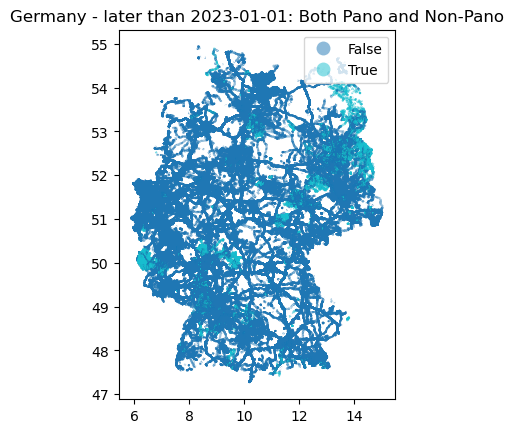

In [6]:
ax = mapillary_coverage.plot(column="is_pano", alpha=0.5, legend=True)
#plt.title("No Time Filter: Both Pano and Non-Pano")
plt.title("Germany - later than 2023-01-01: Both Pano and Non-Pano")

In [10]:
bland = gpd.read_file("https://raw.githubusercontent.com/isellsoap/deutschlandGeoJSON/main/2_bundeslaender/1_sehr_hoch.geo.json")
bland=bland[bland["id"].isin(["DE-BE"])]

In [11]:
bland.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Text(0.5, 1.0, 'Berlin - later than 2023-01-01: Both Pano and Non-Pano')

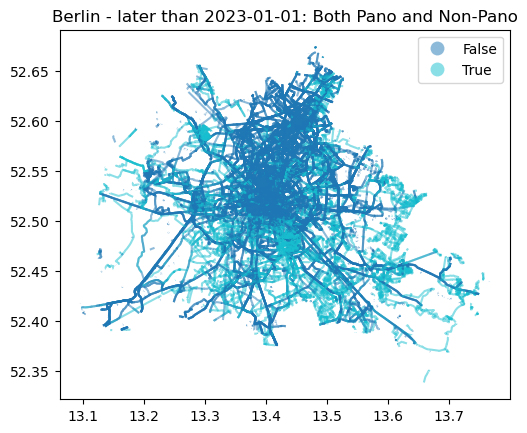

In [12]:
mapillary_coverage_clipped = mapillary_coverage.clip(bland)

ax = mapillary_coverage_clipped.plot(column="is_pano", alpha=0.5, legend=True)
#plt.title("No Time Filter: Both Pano and Non-Pano")
plt.title("Berlin - later than 2023-01-01: Both Pano and Non-Pano")

In [9]:
from datetime import datetime
import pandas as pd

# Convert 'captured_at' to datetime
mapillary_coverage_clipped['captured_at'] = pd.to_datetime(mapillary_coverage_clipped['captured_at'])

# Create a naive Timestamp with the desired date (no timezone information)
filter_date = pd.Timestamp(datetime(2024, 1, 1))

# Filter rows where 'captured_at' is after January 1, 2023
filtered_mapillary_coverage = mapillary_coverage_clipped[
    mapillary_coverage_clipped['captured_at'] >= filter_date
]

Text(0.5, 1.0, 'later than 2024-01-01: Both Pano and Non-Pano')

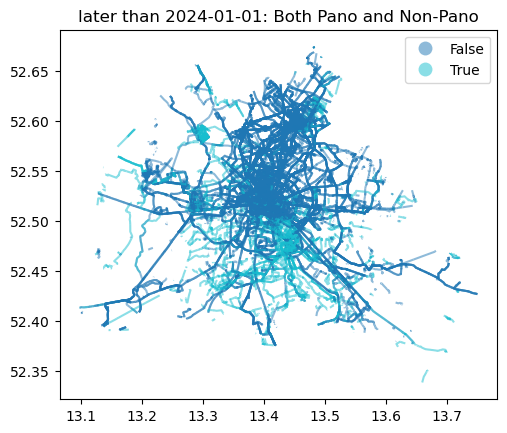

In [10]:
from datetime import datetime, timezone
ax = filtered_mapillary_coverage.plot(column="is_pano", alpha=0.5, legend=True)
plt.title("later than 2024-01-01: Both Pano and Non-Pano")

In [ ]:

# berlin both pano and non-pano ~ 1min
## Germany: both pano and non-pano ~ 25min

## 25-05-12:
## Germany: both pano and non-pano ~ 11min


#input_file = mapillary_coverage_clipped
input_file = mapillary_coverage



#filtered_mapillary_coverage_pano=mapillary_coverage[mapillary_coverage.is_pano==True]

# expolde the geometry to make buffering faster
mapillary_coverage_exploded = input_file.explode(index_parts=False, ignore_index=True)

# create 10m buffers for all the lines
mapillary_coverage_buffered = mapillary_coverage_exploded.to_crs(25832).copy()
mapillary_coverage_buffered['geometry'] = mapillary_coverage_buffered['geometry'].buffer(10)

# dissolve the buffered geometries for pano and non-pano
#mapillary_coverage_dissolved = mapillary_coverage_buffered.dissolve(by=['tile_x', 'tile_y'])

# ## for all (pano and non-pano)
# mapillary_coverage_buffered_regular=mapillary_coverage_buffered[mapillary_coverage_buffered.is_pano==False]
# mapillary_coverage_dissolved_regular = mapillary_coverage_buffered.dissolve(by=['tile_x', 'tile_y'])

# # for pano only
# mapillary_coverage_buffered_pano=mapillary_coverage_buffered[mapillary_coverage_buffered.is_pano==True]
# mapillary_coverage_dissolved_pano = mapillary_coverage_buffered_pano.dissolve(by=['tile_x', 'tile_y'])


mapillary_coverage_dissolved = mapillary_coverage_buffered.dissolve(by=['tile_x', 'tile_y','is_pano'])


#mapillary_coverage_dissolved_all=mapillary_coverage_dissolved_all.reset_index()
#mapillary_coverage_dissolved_pano=mapillary_coverage_dissolved_pano.reset_index()

mapillary_coverage_dissolved=mapillary_coverage_dissolved.reset_index()

#mapillary_coverage_dissolved.to_parquet("mapillary_coverage_23_germany_buffered10m_dissolved_pano_25-04-06.parquet")
#mapillary_coverage_dissolved.to_parquet("mapillary_coverage_23_germany_buffered10m_dissolved_all_25-04-06.parquet")


#mapillary_coverage_dissolved_all.to_parquet("mapillary_coverage_23_berlin_buffered10m_dissolved_all_25-04-06_test.parquet")
#mapillary_coverage_dissolved_pano.to_parquet("mapillary_coverage_23_berlin_buffered10m_dissolved_pano_25-04-06_test.parquet")



In [12]:
mapillary_coverage_dissolved.columns

Index(['tile_x', 'tile_y', 'is_pano', 'geometry', 'captured_at', 'creator_id',
       'id', 'image_id', 'organization_id'],
      dtype='object')

In [13]:
mapillary_coverage_dissolved_cleaned = mapillary_coverage_dissolved[['tile_x', 'tile_y', 'is_pano', 'geometry']].copy()

<Axes: >

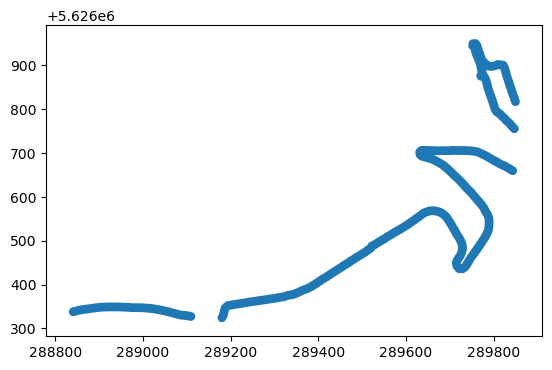

In [19]:
mapillary_coverage_dissolved_cleaned[mapillary_coverage_dissolved_cleaned.is_pano==True][:1].plot()

In [ ]:
## todo: keep only tile_x	tile_y	is_pano	geometry; other columns are not needed and also wrong (dissolve)

In [20]:
#mapillary_coverage_dissolved_all.to_parquet("mapillary_coverage_23_berlin_buffered10m_dissolved_all_2025-05-10.parquet")
#mapillary_coverage_dissolved_pano.to_parquet("mapillary_coverage_23_berlin_buffered10m_dissolved_pano_2025-05-10.parquet")


#mapillary_coverage_dissolved.to_parquet("mapillary_coverage_23_berlin_buffered10m_dissolved_2025-05-10.parquet")

mapillary_coverage_dissolved_cleaned.to_parquet("output_germany_2025-05_combined/mapillary_coverage_germany_buffered10m_dissolved_23-01-01_until_25-05-11.parquet")